# Introduction

The second project that you will complete this semester is to design, implement, and test a controller that applies torque to the wheels of a differential-drive segbot to keep it upright while driving in a rotating space station:

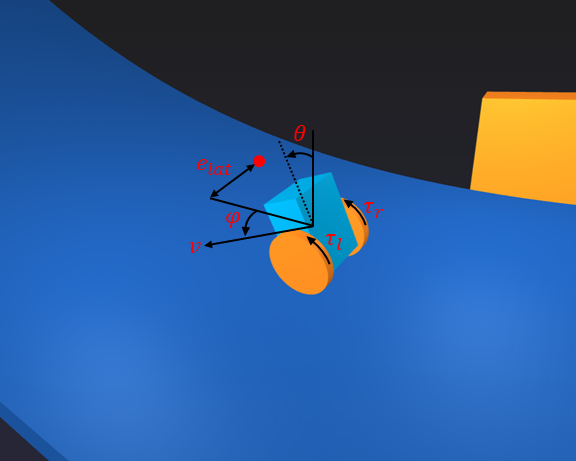

This system consists of a chassis (light blue), a left wheel (orange), and a right wheel (orange). It is called “differential-drive” because two separate motors allow a different torque to be applied to the left wheel and the right wheel:
* If both wheels are rotating forward at the same rate, the robot moves straight.  
* If the left wheel is rotating forward faster than the right wheel, the robot turns right.  
* If the right wheel is rotating forward faster than the left wheel, the robot turns left.  

The end user will be given a keyboard interface that allows them to change the desired lateral location of the segbot in real time. In the simulation, this lateral location is represented as a red arrow. The job of your controller is to get the robot there while keeping it balanced upright.

# Context

A differential-drive transmission is a common design choice for mobile robots. For example, NASA used it in a prototype of [Robonaut](https://robonaut.jsc.nasa.gov/R1/sub/mobility.asp). You can read more about the reasons why in the textbook [Introduction to Autonomous Mobile Robots, Second Edition (Siegward, Nourbakhsh, and Scaramuzza, 2011)](https://mitpress.mit.edu/books/introduction-autonomous-mobile-robots-second-edition), also [available online](https://ieeexplore.ieee.org/book/6267528) (for free from the [library at Illinois](https://ieeexplore-ieee-org.proxy2.library.illinois.edu/servlet/opac?bknumber=6267528) and at other academic institutions). The two-wheeled, differential-drive design has, of course, also been popularized by [Segway](https://www.segway.com/robotics/commercial/).

[Artificial gravity](https://tbretl.github.io/ae353-sp23/(https://en.wikipedia.org/wiki/Artificial_gravity)) is one way to keep a mobile robot anchored to a space station. In particular, if the space station is rotating with angular velocity $\omega_{station}$, and if the radius of the station — the distance from the center of rotation to its inner surface — is $r_{station}$, then the robot will “feel” as if it were being pulled outward by gravity with acceleration equal to the centripetal accleration
$$
g=r_{station}\omega^{2}_{station}
$$

Artificial gravity is also one way to mitigate the health impacts of microgravity on human astronauts. For example, astronauts lose more than 1% of mineral density in weight-bearing bones for each month they are in zero gravity (see [The Human Body in Space](https://www.nasa.gov/hrp/bodyinspace) for more information).

Many [assessments of artificial gravity]() in space missions have been performed by NASA and others, resulting in concepts like [Nautilus-X](https://en.wikipedia.org/wiki/Nautilus-X) or the [Voyager Space Station](https://orbitalassembly.com/), a “space hotel” pictured below that may begin construction as early as 2026:

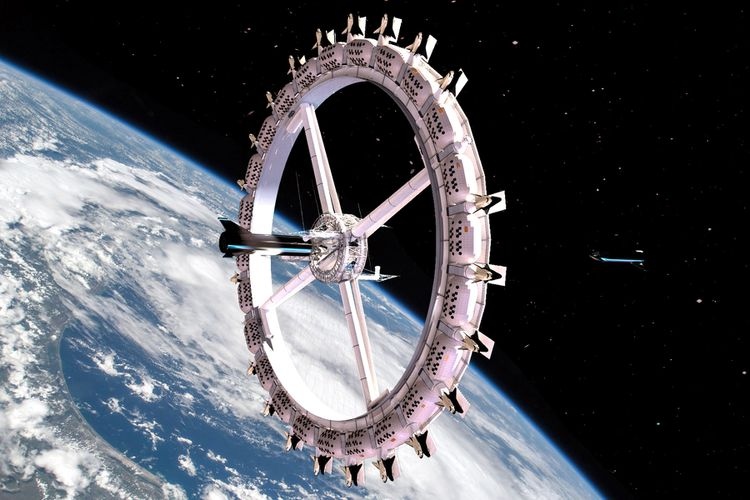

# System Dynamics and Equations of Motion

The first step we will take will be to derive the equations of motion of the system. We  will do this using the approach given in [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses). We can do this using the Python package Sympy.

In [ ]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix
from sympy import N as N_sympy
from sympy import simplify, sin, cos, init_printing
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

Now we are going to define the parameters of the system as constants:

In [ ]:
# Constants of the system
m_c = 12.0    # Mass of the chassis in kg
ixx_c = 1.0   # Roll mass moment of ineria of the chassis
iyy_c = 0.8   # Pitch mass moment of interia of the chassis
izz_c = 0.52  # Yaw mass moment of interia of the chassis

m_w = 1.2       # Mass of either wheel in kg
iaa_w = 0.0634  # Axial mass moment of interia of the wheels
itt_w = 0.0327  # Transverse mass moment of interia of the wheels
r_w = 0.325     # Radius of either wheel in meters

m = m_c + 2*m_w        # The total mass of the system
ixx = ixx_c + 2*itt_w  # The total roll mass moment of inertia of the system
iyy = iyy_c            # The total pitch mass moment of inertia of the system
izz = izz_c + 2*itt_w  # The total yaw mass moment of inertia of the system

h = 0.2   # Distance from the CoM of the chassis to wheel axle in meters
a = 0.35  # Half the distance between the wheels in meters

r_station = 20.0  # The radius of the station in meters
v_station = -0.1  # The angular velocity of the station in rad/second

Now we make symbols and functions. These are elements of SymPy and can be thought of as exactly the same as symbols (variables) and functions from math.

In [ ]:
# Create the system's generalized coordinates 
e_lat = Symbol('e_lat')          # The lateral error of the segbot. Positive is to the left of the target position.
phi = Symbol('phi')              # The yaw of the chassis of the segbot relative to the station. Positive is facing left.
phidot = Symbol('phidot')        # The yawing velocity of the segbot relative to the station. Positive is turning left.
v = Symbol('v')                  # The forward velocity of the segbot. Positive is moving forward.
theta = Symbol('theta')          # The pitch of the chassis of the segbot. Positive is tipped forwards.
thetadot = Symbol('thetadot')    # The pitching velocity of the segbot. Positive is tipping forward.
tau_l = Symbol('tau_l')          # The torque applied to the left wheel of the segbot. Positive moves the segbot forward.
tau_r = Symbol('tau_r')          # The torque applied to the right wheel of the segbot. Positive moves the segbot forward.


Now we apply the method given in [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses).

In [ ]:
M = Matrix([[m + 2 * iaa_w / r_w**2, 0, m_c * h * cos(theta)],
            [0, (ixx + m_c * h**2) * sin(theta)**2 + izz * cos(theta)**2 + (2 * iaa_w * a**2 / r_w**2) + 2 * m_w * a**2, 0],
            [m_c * h * cos(theta), 0, iyy * m_c * h**2]])
N = Matrix([[m_c * h * (phidot**2 + thetadot**2) * sin(theta)],
            [-2 * (ixx - izz + m * h**2) * cos(theta) * sin(theta) * phidot * thetadot - m_c * h * sin(theta) * v * phidot],
            [(ixx - izz + m_c * h**2) * cos(theta) * sin(theta) * phidot**2 + m_c * 9.81 * h * sin(theta)]])
R = Matrix([[1 / r_w, 1 / r_w],
            [-a / r_w, a / r_w],
            [-1, -1]])
f_partial = simplify(M.inv() * (N + R * Matrix([[tau_l], [tau_r]])))
f = Matrix([[v * sin(phi)],
            [f_partial]])
f = simplify(f)

$f$ is our system model such that
$$
\begin{bmatrix}
\dot{e_{lat}} \\
\dot{v} \\
\ddot{\phi} \\
\ddot{\theta}
\end{bmatrix} = f(e_{lat}, v, \phi, \dot{\phi}, \theta, \dot{\theta}, \tau_l, \tau_r)
$$

In [ ]:
N_sympy(f, 3)  # This rounds floating point number to 3 places and then prints to the screen

Note that this system of equations is not in standard form — you will have to do this, as usual.

# FIXME: System Linearization and State Space Form

In [ ]:
# >>>>>FIXME>>>>> Place the system in standard form, linearize it, and calculate the A and B matrices.

# FIXME: Gain Selection and Controller Design

In [ ]:
# >>>>>FIXME<<<<<: Guess a gain matrix and ensure the closed-loop system is stable.

In [ ]:
# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # >>>>>FIXME<<<<<: Replace the following with your own __init__ function
        pass
    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # >>>>>FIXME<<<<<: Replace the following your own reset function
        pass 

    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["e_lat"] : Float
                The current lateral position error of the segbot in meters.
            
            kwargs["v"] : Float
                The current forward velocity of the segbot in meters/second.
            
            kwargs["phi"] : Float
                The current heading angle of the chassis in radians.
            
            kwargs["phidot"] : Float
                The current heading  angular rate of the chassis in radians/second.
            
            kwargs["theta"] : Float
                The current pitch angle of the chassis in radians.
            
            kwargs["thetadot"] : Float
                The current pitch angular rate of the chassis in radians/second.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are two inputs, the torque applied to the left wheel
            and the torque applied to the right wheel. Therefore, inputs has the 
            form:
            inputs = [left_torque, right_torque]
        
        """
        # >>>>>FIXME<<<<<: Replace the following manual controller your own controller
        left_torque = 0.0
        right_torque = 0.0
        
        if kwargs["sw"]:
            right_torque += 0.7
            left_torque += 0.7
        elif kwargs["w"]:
            right_torque += 0.3
            left_torque += 0.3

        if kwargs["ss"]:
            right_torque += -0.7
            left_torque += -0.7
        elif kwargs["s"]:
            right_torque += -0.3
            left_torque += -0.3

        if kwargs["sd"]:
            right_torque += 0.3
        elif kwargs["d"]:
            right_torque += 0.15

        if kwargs["sa"]:
            left_torque += 0.3
        elif kwargs["a"]:
            left_torque += 0.15
    
        # Return the manually set torque
        inputs = [left_torque, right_torque]
        return inputs

In [ ]:
# Create an instance of our Controller class
controller = Controller()

# Running the Simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [ ]:
# Import the segbot project. This module is used to simulate, render, and plot a segbot dynamic system
import ae353_segbot

There are four main parameters to the Segbot_sim class initialization function:
#### Parameters

> **use_keyboard** : *bool, optional*  
> A boolean flag that indicates whether the simulation will allow the use of keyboard interactivity. The default is True.
> 
> **visualization** : *bool, optional*  
> A boolean flag that indicates whether the simulation will be  visualized in meshcat. The default is True.
> 
> **animation** : *bool, optional*  
> A boolean flag that indicates whether animated plots are created in real time. The default is True.
> 
> **bumpy**: *bool, optional*  
> A boolean flag that indicates whether the station will be built with bumps on the driving surface or not.

In [ ]:
sim = ae353_segbot.Segbot_sim(use_keyboard=True,
                              visualization=True,
                              animation=False,
                              bumpy=False)

Now we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes an instance of the ``Controller`` class as an argument and returns ``data``. The parameters and return values of ``sim.run()`` are shown below.

#### Parameters

> **controller** : *member of Controller class*  
> Your controller that will generated inputs to the system.
> 
> **max_time** : *Float or None, optional*  
> The total amount of time the simulation is allowed to run. If set to None, the simulation will run until "ESC" is pressed on the keyboard. If the keyboard is disabled, and max_time is set to None, the simulation will automatically terminate after 10 seconds of simulated time. The default value is None.
> 
> **initial_e_lat** : *Float, optional*  
> The initial lateral error in meters. Changes the target lateral error, does not change the lateral position of the segbot. The default value is 0.0.
> 
> **station_velocity** : *Float, optional*  
> The constant rotational speed of the station in rad/s. The default value is -0.1.

#### Returns

> **data** : *Dictionary of Lists*  
> A dictionary containing all relevant data generated during the simulation. Specific data is extracted via the statement: data["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys of data for this project are as follows:
>  
> **data["lat_pos"]** : *List of Floats*  
> A list of the lateral position of the segbot in meters at each time stamp during the simulation.
>  
> **data["tag_lat"]** : *List of Floats*  
> A list of the taget lateral position of the segbot in meters at each time stamp during the simulation.  
>  
> **data["e_lat"]** : *List of Floats*  
> A list of the lateral position error of the segbot in meters at each time stamp during the simulation.
>  
> **data["v"]** : *List of Floats*
> test
>  
> A list of the forward velocity of the segbot in meters/second at each time stamp during the simulation.
> 
> **data["phi"]** : *List of Floats*  
> A list of the heading angle of the chassis in radians at each time stamp during the simulation.
> 
> **data["phidot"]** : *List of Floats*  
> A list of the heading  angular rate of the chassis in radians/second at each time stamp during the simulation.
> 
> **data["theta"]** : *List of Floats*  
> A list of the pitch angle of the chassis in radians at each time stamp during the simulation.
> 
> **data["thetadot"]** : *List of Floats*  
> A list of the pitch angular rate of the chassis in radians/second at each time stamp during the simulation.
> 
> **data["tau_l"]** : *List of Floats*  
> A list of the torque applied to the left wheel of the segbot in Newton-meters at each time stamp during the simulation.
> 
> **data["tau_r"]** : *List of Floats*  
> A list of the torque applied to the right wheel of the segbot in Newton-meters at each time stamp during the simulation.
> 
> **data["time"]** : *List of Floats*  
> A list of the time stamps in seconds.

#### If enabled you can use the keyboard to interact with the simulation:  
> press **ENTER** to start the simulation  
> press **BACKSPACE** to reset the simulation  
> press **SPACE** to pause the simulation  
> press **ESC** to end the simulation  

#### To control the target lateral position:
> press **j** to move the target to the left  
> press **l** to move the target to the right  

#### If the manual controller is being used:
> press **w** to apply small forward torque to both wheels  
> press **SHIFT+w** to apply large forward torque to both wheels  
> press **s** to apply small backward torque to both wheels  
> press **SHIFT+s** to apply large backward torque to both wheels  
> press **d** to apply small forward torque to only the left wheel  
> press **SHIFT+d** to apply large forward torque to only the left wheel  
> press **a** to apply small backward torque to only the right wheel  
> press **SHIFT+a** to apply large backward torque to only the right wheel  

In [ ]:
# Run the simulation and collect the simulation data
data = sim.run(controller,
               max_time=None,
               initial_e_lat = 0.0,
               station_velocity = v_station)

# Post-processing the simulation data

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib.

In [ ]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

Now we can make whichever plots we see fit to make sense of the simulation data. Here we plot the pitch versus time as well as the applied torques versus time.

**THIS IS LEFT INTENTIONALLY AS INSUFFICIENT TO PROVE YOUR CONTROLLER CAN STEER THE SEGBOT.**

In [ ]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the pitch angle versus time on the first plot
axes[0].plot(data['time'], 180.*np.array(data['theta'])/np.pi, c='k', lw=2.5)
axes[0].set_ylabel("Pitch [deg]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Pitch vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['tau_l'], label="Left Torque", c='r', lw=2.5)
axes[1].plot(data['time'], data['tau_r'], label="Right Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()